In [2]:
import sys
sys.path.append(r'E:\phoneme_recognizer')

import pandas as pd
import torch
import torchaudio
import librosa
import numpy as np

print(torch.__version__)
print(torchaudio.__version__)

import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import ArcticDataset, TIMITDataset

from bokeh.models import ColumnDataSource
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from bokeh.plotting import figure, show, save
from bokeh.io import curdoc, output_file, output_notebook

from sklearn.preprocessing import MinMaxScaler
from bokeh.models import Ellipse

curdoc().theme = 'caliber'
output_notebook()

1.13.1+cpu
0.13.1+cpu


Loading BokehJS ...

## Audio utils

In [3]:
def play_audio(data: np.ndarray, rate: int) -> None:
    display(Audio(data, rate=rate))


def plot_waveform(data: np.ndarray, rate: int) -> None:
    plt.figure(figsize=(14, 5))
    plt.plot(data / 2 ** 15)
    plt.show()


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title('Spectrogram (dB)')
    axs.set_ylabel('freq bin')

    spec = spec.numpy()
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show()


def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Filter bank')
    axs.imshow(fbank, aspect='auto')
    axs.set_ylabel('frequency bin')
    axs.set_xlabel('mel bin')
    plt.show(block=False)

## Dataset and labeling

In [101]:
from typing import Optional


class PhonemeLabeler:
    def __init__(self, phoneme_classes: dict[str, list], mode: Optional[str] = 'default'):
        self.mode = mode
        self.phoneme_classes = phoneme_classes

    def __getitem__(self, phoneme_label: str) -> str:
        if self.mode == 'default':
            return phoneme_label
        else:
            for phoneme_class, phoneme_labels in self.phoneme_classes.items():
                if phoneme_label in phoneme_labels:
                    return phoneme_class
            else:
                return phoneme_label.lower()


phoneme_classes = {
    'vowels': ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW',
               'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW',
               'UX', 'ER', 'AX', 'IX', 'AXR', 'AH-H'],
    'stops': ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q'],
    'nasals': ['M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX'],
    'affricates': ['JH', 'CH'],
    'fricatives': ['S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'DH'],
    'semivowels_glides': ['L', 'R', 'W', 'Y', 'HH', 'HV', 'EL'],
    'timit_extension': ['AX-H', 'ENG', 'HV', 'BCL', 'DCL', 'GCL',
                        'KCL', 'PCL', 'TCL'],
    'others': ['PAU', 'EPI', 'H#']
}

similar_phonemes = {
    'iy' : ['IY'],
    'ih, ix': ['IH', 'IX'],
    'eh': ['EH'],
    'ae': ['AE'],
    'ax, ah, ax-h': ['AX', 'AH', 'AX-H'],
    'uw, ux': ['UW', 'UX'],
    'uh': ['UH'],
    'ao, aa': ['AO', 'AA'],
    'ey': ['EY'],
    'ay': ['AY'],
    'oy': ['OY'],
    'aw': ['AW'],
    'ow': ['OW'],
    'r': ['R'],
    'w': ['W'],
    'y': ['Y'],
    'v': ['V'],
    'f': ['F'],
    'dh': ['DH'],
    'th': ['TH'],
    'z': ['Z'],
    's': ['S'],
    'jh': ['JH'],
    'ch': ['CH'],
    'b': ['B'],
    'p': ['P'],
    'd': ['D'],
    'dx': ['DX'],
    't': ['T'],
    'g': ['G'],
    'k': ['K'],
    'hh, hv': ['HH', 'HV'],
    'er, axr': ['ER', 'AXR'],
    'l, el': ['L', 'EL'],
    'm, em': ['M', 'EM'],
    'n, en, nx': ['N', 'EN', 'NX'],
    'zh, sh': ['ZH', 'SH'],
    'bcl, pcl, dcl, tcl, gcl': ['BCL', 'PCL', 'DCL', 'TCL', 'GCL'],
    'kcl, q, epi, pau, h': ['KCL', 'Q', 'EPI', 'PAU', 'H'],
    'h#': ['H#'],
    'ng, eng': ['NG', 'ENG']
}

custom_classes = {
    'vowels': ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW',
               'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW',
               'UX', 'ER', 'AX', 'IX', 'AXR', 'AH-H'],
    'consonants': ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q',
                   'M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX',
                   'JH', 'CH',
                   'S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'DH',
                #    'L', 'R', 'W', 'Y', 'HH', 'HV', 'EL'
                   ],
    'semivowels_glides': ['L', 'R', 'W', 'Y', 'HH', 'HV', 'EL'],
    'others': ['PAU', 'EPI', 'H#'],
    'timit_extension': ['AX-H', 'ENG', 'HV', 'BCL', 'DCL', 'GCL',
                        'KCL', 'PCL', 'TCL'],

}

PhonemeLabeler(custom_classes, '')['B']

'consonants'

In [102]:
timit_dataset = TIMITDataset(usage='train',
                                    root_dir=r'E:\voice_datasets\timit\TIMIT_2\data',
                                    percentage=0.05,
                                    padding=8000,
                                    description_file_path='../data/timit_description.csv',
                                    # dialect=['Northern'],
                                    # phone_codes=['vowels', 'stops', 'nasals', 'affricates', 'fricatives', 'semivowels_glides'],
                                    # phone_codes=['vowels', 'consonants', 'semivowels_glides'],
                                    phoneme_labeler=PhonemeLabeler(similar_phonemes, ''))

In [103]:
timit_dataset.description_table.phone_name

90243      IY
80364       K
127287      L
160278     EH
101936      T
         ... 
95594       T
202621      M
71225       Z
165666    AXR
115732     IX
Name: phone_name, Length: 8854, dtype: object

<AxesSubplot: ylabel='phone_class'>

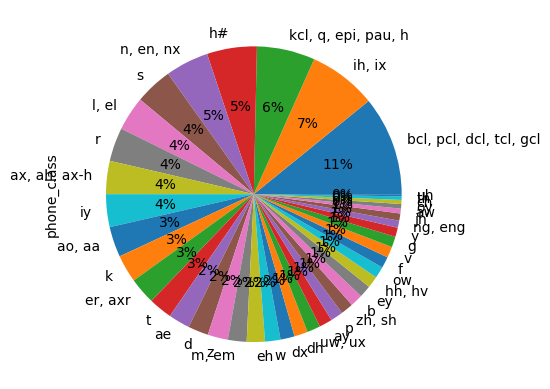

In [104]:
timit_dataset.description_table.phone_class.value_counts(normalize=True).plot.pie(autopct='%1.0f%%')

In [105]:
len(timit_dataset)

8854

## MFCC, T-SNE, Scaling

### Parameters

##### MFCC

In [106]:
n_fft = 512
win_length = None
hop_length = 128
n_mels = 64
n_mfcc = 20

##### T-SNE

In [107]:
perplexity = 30

In [116]:
def get_mfcc(data, n_fft, hop_length, n_mels, n_mfcc):
    return T.MFCC(
        sample_rate=16000,
        n_mfcc=n_mfcc,
        melkwargs={
            'n_fft': n_fft,
            'n_mels': n_mels,
            'hop_length': hop_length,
        }
    )(data)


def get_tsne_embeddings(data: np.ndarray, perplexity: int = 5) -> np.ndarray:
    return TSNE(
        n_components=2,
        perplexity=perplexity,
        init='pca',
        learning_rate='auto').fit_transform(data)

def min_max_scale_data(data):
    return MinMaxScaler().fit_transform(data)


def full_transform(dataset, n_fft, hop_length, n_mels, n_mfcc,  perplexity):
    data = np.stack([get_mfcc(waveform.data,  n_fft, hop_length, n_mels, n_mfcc).squeeze(0).flatten() for waveform in dataset], axis=0)
    labels = [waveform.label for waveform in dataset]

    data = get_tsne_embeddings(data, perplexity=perplexity)
    data = min_max_scale_data(data)

    return data, labels

def filter_table(table, dialect=None, gender=None, phone_class=None):
    if dialect is not None:
        table = table.loc[table.dialect==dialect]
    
    if gender is not None:
        table = table.loc[table.speaker_gender==gender]

    if phone_class is not None:
        table = table.loc[table.phone_class==phone_class]

    table = table.loc[:, ['feature1', 'feature2', 'phone_class']]

    data = table.iloc[:, [0, 1]].to_numpy()
    labels = table.iloc[:, [2]].values.squeeze().tolist()

    return data, labels


def stat_analysis(table, dialect=None, gender=None):
    if dialect is not None:
        table = table.loc[table.dialect==dialect]
    
    if gender is not None:
        table = table.loc[table.speaker_gender==gender]

    table = table.loc[:, ['feature1', 'feature2', 'phone_class']]

    return table.groupby('phone_class').agg(['mean', 'std']) 


def get_confidence_ellipse(data, n_std=3.0):
    x = data[:, 0]
    y = data[:, 1]

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std

    width = ell_radius_x * scale_x
    height = ell_radius_y * scale_y

    lambda_, v = np.linalg.eig(cov)
    theta = np.rad2deg(np.arctan2(v[0,1], v[0,0]))

    return mean_x, mean_y, width, height, theta

def get_many_ellipses(table, color_map):
    

    mean_xs = list()
    mean_ys = list()
    widths = list()
    heights = list()
    thetas = list()
    colors = list()

    #### КОСТЫЛЬ !!!
    
    # table['phone_class'] = table['phone_class'].replace(['semivowels_glides'], 'consonants')
    
    #### КОСТЫЛЬ !!!
    print(table.phone_class.unique())

    phone_classes = table.phone_class.unique()
    for phone_class in phone_classes:
        print(f'phone class: {phone_class}')
        data, labels = filter_table(table, phone_class=phone_class)
        mean_x, mean_y, width, height, theta = get_confidence_ellipse(data=data)
        mean_xs.append(mean_x)
        mean_ys.append(mean_y)
        heights.append(height)
        widths.append(width)
        thetas.append(theta)
        colors.append(color_map[phone_class])
    #### КОСТЫЛЬ !!!

    # print(thetas)
    thetas[0] = - 170

    thetas[3] = 80

    #### КОСТЫЛЬ !!!
    return table, ColumnDataSource(dict(
            mean_x = mean_xs,
            mean_y = mean_ys,
            height = heights,
            width = widths,
            theta = thetas,
            color = colors
        )
    )
    

def plot_matplotlib_embedding(data, labels, color_map, title: str, figsize: tuple = (15, 15)):
    data = MinMaxScaler().fit_transform(data)
    fig, ax = plt.subplots(figsize=figsize)
    for idx, label in enumerate(labels):
        try:
            ax.scatter(
                *data[idx],
                marker=f'${label}$',
                s=60,
                color=color_map[label]
            )
        except KeyError as err:
            print(f'{err}: label {label} is absent')
    ax.legend(color_map)
    ax.set_title(title)


def plot_bokeh_embedding(
    table,
    gender,
    dialect,
    color_map,
    title: str,
    figsize: tuple = (1600, 1200),
    form='text'):

    table, ellipses = get_many_ellipses(table.copy(), color_map)

    data, labels = filter_table(table, gender, dialect)


    source = ColumnDataSource(data=dict(
        x=data[:, 0],
        y=data[:, 1],
        label=labels,
        colors=[color_map[label] for label in labels]
    ))
    output_file(filename=f'{title}.html')

    tooltips = [
        ('x, y', '@x, @y'),
        ('phoneme', '@label')
    ]
    p = figure(
        title=title,
        x_axis_label='x',
        y_axis_label='y',
        tooltips=tooltips
    )

    # p.ellipse(x="mean_x", y="mean_y", width="width", height="height", angle='theta', source=ellipses, fill_color='color', fill_alpha=0.2)

    if form == 'circle':
        p.circle(x='x', y='y', fill_color='colors', legend_group='label', source=source, size=10)
    else:  # form == 'text'
        p.text(x='x', y='y', text_color='colors', text='label', source=source, text_font_size='12px',
               text_font_style='bold')

    p.width = figsize[0]
    p.height = figsize[1]
    # save(p)
    show(p)

In [109]:
timit_dataset.description_table

,phone_name,phone_class,usage,speaker_id,speaker_gender,dialect,wav_file_path,t0,t1
90243,IY,iy,train,DLC2,M,Northern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR2...,2.690,2.748
80364,K,k,train,CYL0,F,Northern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR2...,0.951,1.013
127287,L,"l, el",train,KXL0,M,North Midland,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR3...,1.491,1.556
160278,EH,eh,train,SMS0,M,South Midland,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR4...,1.868,1.970
101936,T,t,train,RHL0,M,Northern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR2...,1.256,1.276
...,...,...,...,...,...,...,...,...,...
95594,T,t,train,JPM0,M,Northern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR2...,1.299,1.380
202621,M,"m, em",train,TJU0,M,New York City,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR6...,0.199,0.253
71225,Z,z,train,GRL0,M,New England,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR1...,0.554,0.622
165666,AXR,"er, axr",train,GDP0,F,Southern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR5...,0.999,1.045


In [110]:
data, labels = full_transform(timit_dataset, n_fft, hop_length, n_mels, n_mfcc,  perplexity)

data

array([[0.41021746, 0.59418994],
       [0.5412103 , 0.628164  ],
       [0.53129965, 0.6405822 ],
       ...,
       [0.55342686, 0.46996546],
       [0.40924495, 0.77374417],
       [0.70290214, 0.7899628 ]], dtype=float32)

In [111]:
timit_dataset.description_table['feature1'] = data[..., 0]
timit_dataset.description_table['feature2'] = data[..., 1]
timit_dataset.description_table

,phone_name,phone_class,usage,speaker_id,speaker_gender,dialect,wav_file_path,t0,t1,feature1,feature2
90243,IY,iy,train,DLC2,M,Northern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR2...,2.690,2.748,0.410217,0.594190
80364,K,k,train,CYL0,F,Northern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR2...,0.951,1.013,0.541210,0.628164
127287,L,"l, el",train,KXL0,M,North Midland,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR3...,1.491,1.556,0.531300,0.640582
160278,EH,eh,train,SMS0,M,South Midland,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR4...,1.868,1.970,0.813194,0.570323
101936,T,t,train,RHL0,M,Northern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR2...,1.256,1.276,0.144708,0.947409
...,...,...,...,...,...,...,...,...,...,...,...
95594,T,t,train,JPM0,M,Northern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR2...,1.299,1.380,0.640641,0.439083
202621,M,"m, em",train,TJU0,M,New York City,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR6...,0.199,0.253,0.319013,0.472988
71225,Z,z,train,GRL0,M,New England,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR1...,0.554,0.622,0.553427,0.469965
165666,AXR,"er, axr",train,GDP0,F,Southern,E:\voice_datasets\timit\TIMIT_2\data\TRAIN\DR5...,0.999,1.045,0.409245,0.773744


In [114]:
import random

def get_color_map(phone_classes):
    get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
    colors = get_colors(len(phone_classes))
    return dict(zip(phone_classes, colors))

In [117]:
color_map = {
    'vowels': 'red',
    'stops': 'pink',
    'nasals': 'lime',
    'affricates': 'orange',
    'fricatives': 'purple',
    'semivowels_glides': 'yellow',
}

# color_map = {
#     'vowels': 'red',
#     'consonants': 'blue',
#     'semivowels_glides': 'yellow'
# }


# data, labels = filter_table(timit_dataset.description_table.copy())

color_map = get_color_map(timit_dataset.description_table.phone_class.unique())

plot_bokeh_embedding(
    table=timit_dataset.description_table.copy(),
    gender=None,
    dialect=None,
    color_map=color_map,
    title='TIMIT: all phonemes',
    form='circle',
    # figsize=(800, 600)
    )

['iy' 'k' 'l, el' 'eh' 't' 'bcl, pcl, dcl, tcl, gcl' 'dx' 'ax, ah, ax-h'
 'ae' 's' 'kcl, q, epi, pau, h' 'ao, aa' 'p' 'r' 'ay' 'h#' 'ih, ix' 'th'
 'zh, sh' 'jh' 'g' 'dh' 'w' 'n, en, nx' 'oy' 'uw, ux' 'ng, eng' 'er, axr'
 'f' 'ow' 'v' 'd' 'aw' 'y' 'ch' 'm, em' 'b' 'ey' 'z' 'uh' 'hh, hv']
phone class: iy
phone class: k
phone class: l, el
phone class: eh
phone class: t
phone class: bcl, pcl, dcl, tcl, gcl
phone class: dx
phone class: ax, ah, ax-h
phone class: ae
phone class: s
phone class: kcl, q, epi, pau, h
phone class: ao, aa
phone class: p
phone class: r
phone class: ay
phone class: h#
phone class: ih, ix
phone class: th
phone class: zh, sh
phone class: jh
phone class: g
phone class: dh
phone class: w
phone class: n, en, nx
phone class: oy
phone class: uw, ux
phone class: ng, eng
phone class: er, axr
phone class: f
phone class: ow
phone class: v
phone class: d
phone class: aw
phone class: y
phone class: ch
phone class: m, em
phone class: b
phone class: ey
phone class: z
phone class: u

<AxesSubplot: ylabel='phone_class'>

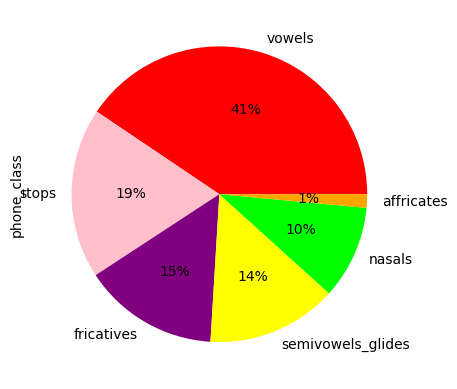

In [86]:
timit_dataset.description_table.phone_class.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', colors=['red', 'pink', 'purple', 'yellow', 'lime', 'orange'])

In [47]:
stat_analysis(timit_dataset.description_table.copy())

feature1            feature2          
                       mean       std      mean       std
phone_class                                              
affricates         0.436947  0.186013  0.397301  0.192080
fricatives         0.558186  0.195152  0.250638  0.199889
nasals             0.374632  0.178268  0.476749  0.195985
semivowels_glides  0.470603  0.178994  0.713154  0.189304
stops              0.245468  0.198221  0.589507  0.212681
vowels             0.630483  0.227680  0.658696  0.174469

In [48]:
data, labels = filter_table(timit_dataset.description_table.copy(), gender='M')

plot_bokeh_embedding(
    data=data,
    labels=labels,
    color_map=color_map,
    title='test',
    form='circle',
    figsize=(800, 600))

TypeError: plot_bokeh_embedding() got an unexpected keyword argument 'data'